In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Calibration
## Preparation of input data
Add zone-specific attributes to the calibration data

In [3]:
input_path = '../input/'
zone_data_path = '../input_static/zones_Gebietsaenderungen/'
model_path = '../model/' + scenario + '/'
output_path = '../output/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Load zonal data
z = stepmodel.read_json(model_path + 'de_zones')
z.zones.sample()

,NUTS_ID,area,population,lat,lon,urbanisation,pop_share,FID,geometry,ARS,name
index,,,,,,,,,,,
DE279_3,DE279,43.22,2780,10.236809,48.304915,3,0.015811,DE279_3,"POLYGON ((10.25848 48.29176, 10.25388 48.29118...","[97750149, 97759454]","[Roggenburg, Stoffenrieder Forst]"


In [6]:
# Load calibration dataset
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
trips = trips.drop(columns='Unnamed: 0').reset_index(drop=True)
print(len(trips.index))

320007


In [7]:
# Load official data sources that describe changes
# in ARS codes within one year (Gebietsänderungen)
col_names = ['n', 'level', 'old_ARS', 'old_AGS', 'old_name',
             'change', 'area', 'population', 'new_ARS', 'new_AGS',
             'new_name', 'date1', 'date2']
def update_ARS_until(end, ars):
    for year in range(2016, end+1):
        changes = pd.read_excel(zone_data_path + str(year) + '.xlsx',
                                sheet_name='Gebietsaenderungen {}'.format(year),
                                header=6, skipfooter=8, index_col=None,
                                names=col_names, na_filter=False)
        changes = changes.loc[(changes['level']=='Gemeindeverband')
                              & (changes['old_ARS']!=changes['new_ARS'])]
        changes['old_ARS'] = changes['old_ARS'].astype(int)
        changes['new_ARS'] = changes['new_ARS'].astype(int)
        update_dict = changes.set_index('old_ARS')['new_ARS'].to_dict()
        ars = ars.replace(update_dict)
    return ars

In [8]:
# Replace LAU codes with NUTS IDs
if not str(trips.loc[0, 'origin']).startswith('DE'):
    # First, update LAU IDs
    trips['origin'] = update_ARS_until(2021, trips['origin'])
    trips['destination'] = update_ARS_until(2021, trips['destination'])
    # Then replace with model's zone IDs
    lau_dict = z.zones[['FID', 'ARS']].explode('ARS').set_index('ARS')['FID'].to_dict()
    trips['origin'] = trips['origin'].map(lau_dict)
    trips['destination'] = trips['destination'].map(lau_dict)

    # Drop all other trips
    trips = trips.loc[(trips['origin'].notna()) & (trips['destination'].notna())]
    print(len(trips.index))
    assert len(trips.loc[trips.isna().any(axis=1)])==0

319867


### Validate survey distances

MiD2017 contains some observations with wrong distances. They neither match routed distances in the survey itself, nor OD-distances from the network model.

<AxesSubplot:>

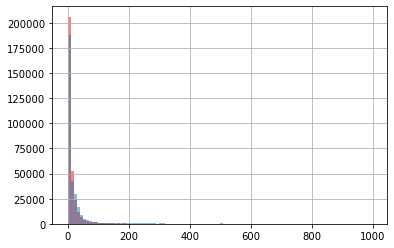

In [9]:
# load and merge network model distances
od_lengths = pd.read_csv(output_path + 'distances_centroids.csv')
trips = trips.merge(od_lengths, how='left',
                    left_on=['origin', 'destination'],
                    right_on=['origin', 'destination'])
trips.drop(trips.loc[(trips['origin']!=trips['destination']) & (trips['length'].isna())].index,
           inplace=True)
trips['length'] = trips['length'].fillna(1)
trips['length'].hist(bins=100, log=False, alpha=.5, ax=trips['distance'].hist(
    bins=100, log=False, alpha=.5, color='red'))

<AxesSubplot:xlabel='length', ylabel='distance'>

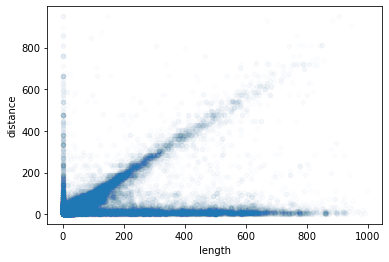

In [10]:
# survey distance (y) vs. model distance (x)
trips.plot.scatter(x='length', y='distance', alpha=.01)

In [11]:
# Generate distance bins
bins = [-1, 20, 50, 100, 300, 1000]
trips['distance_group'] = pd.cut(trips['distance'], bins=bins, labels=bins[1:]).astype(int)
trips['length_group'] = pd.cut(trips['length'], bins=bins, labels=bins[1:]).astype(int)

<AxesSubplot:xlabel='distance_group'>

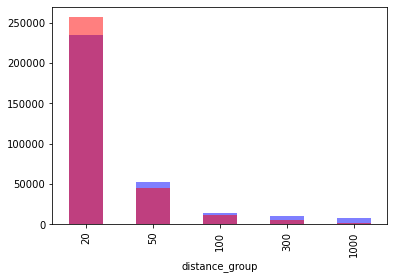

In [12]:
# number of trips per distance bin: survey (red) vs. model (blue)
trips.groupby('distance_group').count()['distance'].plot.bar(color='red', alpha=.5,
    ax=trips.groupby('length_group').count()['length'].plot.bar(color='blue', alpha=.5))

<AxesSubplot:>

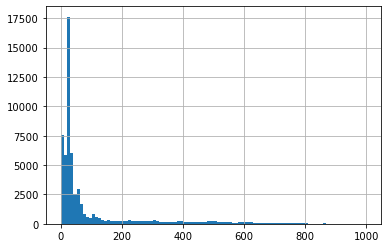

In [13]:
# Distance distribution of erronous trips
to_drop = trips.loc[(trips['distance_group']!=trips['length_group'])].index
trips.loc[to_drop, 'length'].hist(bins=100)

<AxesSubplot:xlabel='length', ylabel='distance'>

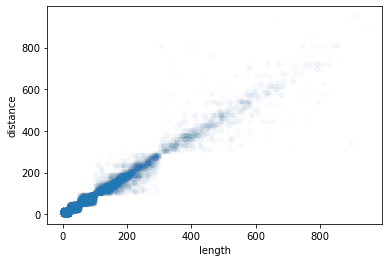

In [14]:
# Distance distribution after dropping erronous trips
trips.drop(to_drop).plot.scatter(x='length', y='distance', alpha=.01)

In [15]:
trips.drop(to_drop, inplace=True)
trips.drop(['length_group', 'distance_group'], axis=1, inplace=True)
len(trips)

260723

## Zone-specific attributes

In [16]:
# Load employment data
employment = pd.read_csv('../input_static/spatial_employed_persons_2017_eurostat.csv', encoding='latin-1')
employment['Value'] = (pd.to_numeric(employment['Value'].str.replace(',', '')) * 1000).astype(int)
# Also, load NUTS-names
nuts = gpd.read_file("../input_static/spatial_NUTS_RG_01M_2016_4326.geojson")
nuts = nuts[(nuts["CNTR_CODE"]=="DE") & (nuts["LEVL_CODE"]==3)]
# Map differing names of zones to names in employment data
name_dict = {'Burgenlandkreis (DE)': 'Burgenlandkreis',
             'Dillingen an der Donau': 'Dillingen a.d. Donau',
             'Mühldorf am Inn': 'Mühldorf a. Inn',
             'Neumarkt in der Oberpfalz': 'Neumarkt i. d. OPf.',
             'Neustadt an der Aisch-Bad Windsheim': 'Neustadt a. d. Aisch-Bad Windsheim',
             'Neustadt an der Waldnaab': 'Neustadt a. d. Waldnaab',
             'Pfaffenhofen an der Ilm': 'Pfaffenhofen a. d. Ilm',
             'Weiden in der Oberpfalz, Kreisfreie Stadt': 'Weiden i. d. Opf, Kreisfreie Stadt',
             'Wunsiedel im Fichtelgebirge': 'Wunsiedel i. Fichtelgebirge'}
employment['GEO'].replace(name_dict, inplace=True)
zone_dict = employment.set_index('GEO')['Value'].to_dict()
name_dict = nuts.set_index('NUTS_ID')['NUTS_NAME'].to_dict()
z.zones['employment'] = z.zones['NUTS_ID'].map(name_dict).map(zone_dict) * z.zones['pop_share']
assert not z.zones['employment'].isna().max()

In [17]:
# Add working places of destination zone
zone_dict = z.zones['employment'].to_dict()
trips['dest_employment'] = trips['destination'].map(zone_dict)

In [18]:
# Add inhabitants of destination zone
zone_dict = z.zones['population'].to_dict()
trips['dest_pop'] = trips['destination'].map(zone_dict)

In [19]:
# Add area of destination zone
zone_dict = z.zones['area'].to_dict()
trips['dest_area'] = trips['destination'].map(zone_dict)

In [20]:
# Add urbanisation of destination zone
zone_dict = z.zones['urbanisation'].to_dict()
trips['dest_urban'] = trips['destination'].map(zone_dict)

In [21]:
# Load zone-specific attraction attributes
attr = pd.read_csv(input_path + 'spatial_num_pois.csv', index_col=0)
purpose_dict={1:'commuting', 2:'official', 3: 'education', 4:'shopping', 5:'shopping', 6:'leisure', 7:'accompany'}

In [22]:
# Add attraction attributes to trips
for p in [3, 4, 6]:
    for suffix in ['_many', '_few']:
        attr_dict = attr[purpose_dict[p]+suffix].to_dict()
        trips['dest_'+purpose_dict[p]+suffix] = trips['destination'].map(attr_dict)
attr_dict = attr[purpose_dict[7]].to_dict()
trips['dest_'+purpose_dict[7]] = trips['destination'].map(attr_dict)

In [23]:
# Load tourisitc attraction values by zone ('Touristic_indicator')
#tourism = pd.read_csv('../input_static/spatial_touristic_attraction_2010.csv',
#                      encoding='latin-1', sep=';', index_col='NUTS_ID')
trips['dest_tourism'] = 0 #trips['destination'].map(tourism['Touristic_indicator'].to_dict())

In [24]:
trips = trips.loc[~trips.isna().any(axis=1)]
len(trips)

260723

### Add cost for inner-zonal trips

If not done yet, add travel times and travel fee for inner zonal trips in oder to generate inner-zonal CC. Inter-zonal values come from mode choice model values.

In [25]:
if not 'time_car' in trips.columns:
    for m in ['rail_short', 'rail_long', 'bus', 'coach', 'car', 'air', 'walk']:
        trips['time_'+m] = np.inf
    inner_mask = trips['origin']==trips['destination']
    
    # PT
    # Inner-zonal bus
    access_time = {1:2, 2:5, 3:8, 4:15, 5:45, 6:80, 95:60, 701: 10
                  } # map distance to bus stop classes to footpath time
    trips.loc[inner_mask, 'time_bus'] = trips.loc[inner_mask, 'distance'] \
        / 18 * 60 + trips.loc[inner_mask, 'dist_bus_origin'].map(access_time) \
        + trips.loc[inner_mask, 'dist_bus_destination'].map(access_time)
    trips['time_road'] = trips['time_bus']
    # Inner-zonal rail
    trips['time_rail'] = np.inf
    trips.loc[inner_mask, 'time_rail'] = trips.loc[inner_mask, 'distance'] \
        / 50 * 60 + trips.loc[inner_mask, 'dist_train_origin'].map(access_time) \
        + trips.loc[inner_mask, 'dist_train_destination'].map(access_time)
    trips.loc[inner_mask, 'time_rail_short'] = trips.loc[inner_mask, 'time_rail']
    # Inner-zonal walk
    trips.loc[inner_mask, 'time_walk'] = trips.loc[inner_mask, 'distance'] / 10 * 60
    # Inner-zonal car
    trips.loc[inner_mask, 'time_car'] = trips.loc[inner_mask, 'distance'] \
        / params['pt_access']['speed_car'] * 60 + params['access-egress_links']['time_road']

In [26]:
if not 'cost_car' in trips.columns:
    # Non-motorised
    trips['cost_walk'] = 0
    # Car: The same assumptions for car travel as in the car LoS generation (prep30)
    vc_car = params['car_var_cost'].to_dict()
    fix_car = params['car_fix_cost'].to_dict()
    parking_cost = params['parking_cost'].to_dict()
    car_av = ['_no_car', '_car']
    trips['cost_car'] = [(d * vc_car[p+car_av[car]] + parking_cost[u]) / n + fix_car[p+car_av[car]] * t/60
                         for d, n, u, t, p, car in zip(trips['distance'], trips['n_persons'],
                                                       trips['urbanisation'], trips['duration'],
                                                       trips['purpose_model'], trips['car_avail'].replace({9:0})
                                                       )]
    # PT
    # Ticket type determines the trip cost
    # Assume this dict with factors
    ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
    # Rail is calculated as rail short-distance, see prep31
    rail_short_slope = params['rail_short']['slope']
    rail_short_intercept = params['rail_short']['intercept']
    trips['cost_rail_short'] = [(d*rail_short_slope + rail_short_intercept) * ticket_dict[t]
                                for d, t in zip(trips['distance'], trips['ticket_type'])]
    trips['cost_rail'] = trips['cost_rail_short']
    trips['cost_rail_long'] = np.inf
    trips['cost_rail'] = np.clip(trips['cost_rail'], 0, params['rail_short']['max'])
    # Bus and tram
    # Trip cost depend on the ticket type and regional type
    # See prep31 for prices
    region_prices = params['bus'].to_dict()
    trips['cost_bus'] = [region_prices[r] * ticket_dict[t]
                         for r,t in zip(trips['urbanisation'], trips['ticket_type'])]
    trips['cost_road'] = trips['cost_bus']
    trips['cost_coach'] = np.inf
    # Air is not available
    trips['cost_air'] = np.inf

## Save calibration dataset

In [27]:
assert len(trips.loc[trips.isna().any(axis=1)])==0

Frequency of zone characteristics


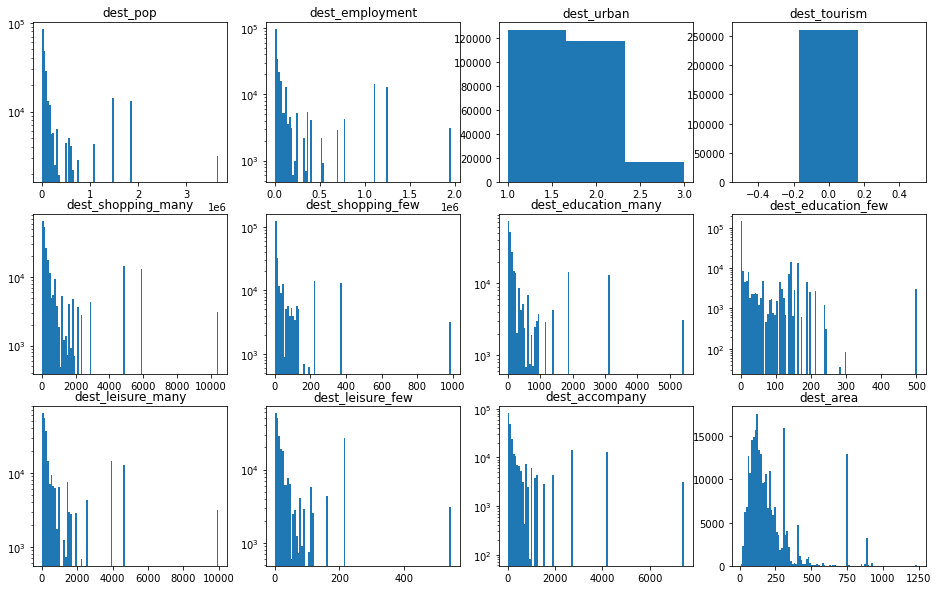

In [29]:
# Plot
if manual:
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16,10))
    ax[0,0].hist(trips['dest_pop'], bins=100, log=True)
    ax[0,1].hist(trips['dest_employment'], bins=100, log=True)
    ax[0,2].hist(trips['dest_urban'], bins=3)
    ax[0,3].hist(trips['dest_tourism'], bins=3)
    ax[1,0].hist(trips['dest_shopping_many'], bins=100, log=True)
    ax[1,1].hist(trips['dest_shopping_few'], bins=100, log=True)
    ax[1,2].hist(trips['dest_education_many'], bins=100, log=True)
    ax[1,3].hist(trips['dest_education_few'], bins=100, log=True)
    ax[2,0].hist(trips['dest_leisure_many'], bins=100, log=True)
    ax[2,1].hist(trips['dest_leisure_few'], bins=100, log=True)
    ax[2,2].hist(trips['dest_accompany'], bins=100, log=True)
    ax[2,3].hist(trips['dest_area'], bins=100, log=False)
    ax[0,0].set_title('dest_pop')
    ax[0,1].set_title('dest_employment')
    ax[0,2].set_title('dest_urban')
    ax[0,3].set_title('dest_tourism')
    ax[1,0].set_title('dest_shopping_many')
    ax[1,1].set_title('dest_shopping_few')
    ax[1,2].set_title('dest_education_many')
    ax[1,3].set_title('dest_education_few')
    ax[2,0].set_title('dest_leisure_many')
    ax[2,1].set_title('dest_leisure_few')
    ax[2,2].set_title('dest_accompany')
    ax[2,3].set_title('dest_area')
    print('Frequency of zone characteristics')

In [30]:
trips.to_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')